# MobileNet V3 Large

### Import libraries

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.applications.mobilenet_v3 import preprocess_input
print(f"TensorFlow Version: {tf.__version__}")

2024-11-15 01:57:41.114306: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1731607061.128080  121811 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1731607061.132301  121811 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-15 01:57:41.147922: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/home/divinevalleys/miniconda3/envs/tf-wsl/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Ple

TensorFlow Version: 2.18.0


In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


### Data Loading and Preprocessing

In [3]:
(ds_train, ds_val, ds_test), ds_info = tfds.load(
    'oxford_flowers102',
    split=['test', 'validation', 'train'],
    shuffle_files=True,
    as_supervised=True,  # Include labels
    with_info=True
)
print(f"Dataset Info:\n{ds_info}")
num_classes = ds_info.features['label'].num_classes
print(f"Number of classes: {num_classes}")

Dataset Info:
tfds.core.DatasetInfo(
    name='oxford_flowers102',
    full_name='oxford_flowers102/2.1.1',
    description="""
    The Oxford Flowers 102 dataset is a consistent of 102 flower categories commonly
    occurring in the United Kingdom. Each class consists of between 40 and 258
    images. The images have large scale, pose and light variations. In addition,
    there are categories that have large variations within the category and several
    very similar categories.
    
    The dataset is divided into a training set, a validation set and a test set. The
    training set and validation set each consist of 10 images per class (totalling
    1020 images each). The test set consists of the remaining 6149 images (minimum
    20 per class).
    
    Note: The dataset by default comes with a test size larger than the train size.
    For more info see this
    [issue](https://github.com/tensorflow/datasets/issues/3022).
    """,
    homepage='https://www.robots.ox.ac.uk/~vgg/da

I0000 00:00:1731607066.902224  121811 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 21769 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:0a:00.0, compute capability: 8.6


In [4]:
IMG_SIZE = 224  # You can adjust this size
BATCH_SIZE = 64

def preprocess(image, label):
    # Resize and normalize images
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    # image = image / 255.0  # Normalize to [0,1]
    return image, label

ds_train = ds_train.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
ds_train = ds_train.shuffle(1000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

ds_val = ds_val.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
ds_val = ds_val.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

ds_test = ds_test.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
ds_test = ds_test.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

### Use V3 base model

In [5]:
v3_model = keras.applications.MobileNetV3Large(
    weights='imagenet',     # Use 'imagenet' for pre-trained weights, or None
    include_top=False,      # Exclude the top classification layers
    input_shape=(224, 224, 3)
)

v3_model.trainable = False

### Wrap it layer

In [6]:
inputs = layers.Input(shape=(224, 224, 3))
x = preprocess_input(inputs)
x = v3_model(inputs, training=False)  # Set training=False if base_model is frozen
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(102, activation='softmax')(x)  # Adjust the number of classes
model = models.Model(inputs, x)
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ MobileNetV3Large (Functional)   │ (None, 7, 7, 960)      │     2,996,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 960)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 102)            │        98,022 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,094,374 (11.80 MB)

 Trainable params: 98,022 (382.90 KB)

 Non-trainable params: 2,996,352 (11.43 MB)

In [7]:
callbacks = [
    keras.callbacks.EarlyStopping(
        patience=50, restore_best_weights=True),
    keras.callbacks.ModelCheckpoint(
        'best_model.keras', save_best_only=True),
]

In [8]:
epochs = 10  # Adjust the number of epochs as needed

history = model.fit(
    ds_train,
    validation_data=ds_val,
    epochs=epochs,
    callbacks=callbacks
)

Epoch 1/10


2024-11-15 01:58:03.572223: I tensorflow/core/kernels/data/tf_record_dataset_op.cc:376] The default buffer size is 262144, which is overridden by the user specified `buffer_size` of 8388608
I0000 00:00:1731607084.014517  121952 service.cc:148] XLA service 0x7f07fc20e570 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1731607084.014556  121952 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2024-11-15 01:58:04.102486: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1731607084.755155  121952 cuda_dnn.cc:529] Loaded cuDNN version 90300
2024-11-15 01:58:05.161156: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_3132', 16 bytes spill stores, 16 bytes spill loads

2024-11-

 3/97 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - accuracy: 0.0330 - loss: 5.2607  

I0000 00:00:1731607092.827606  121952 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


96/97 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.2515 - loss: 3.6229

2024-11-15 01:58:17.153213: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_3288', 8 bytes spill stores, 8 bytes spill loads

2024-11-15 01:58:17.199829: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_3288', 16 bytes spill stores, 16 bytes spill loads

2024-11-15 01:58:17.215190: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_3288', 12 bytes spill stores, 12 bytes spill loads

2024-11-15 01:58:17.339364: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_3132', 16 bytes spill stores, 16 bytes spill loads



97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 0.2538 - loss: 3.6122

2024-11-15 01:58:26.517310: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1539', 72 bytes spill stores, 72 bytes spill loads

2024-11-15 01:58:26.542194: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1539', 120 bytes spill stores, 120 bytes spill loads

2024-11-15 01:58:26.680759: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1539', 572 bytes spill stores, 448 bytes spill loads

2024-11-15 01:58:26.756890: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1539', 44 bytes spill stores, 44 bytes spill loads

2024-11-15 01:58:26.822053: I external/local_xla/xla/str

97/97 ━━━━━━━━━━━━━━━━━━━━ 34s 216ms/step - accuracy: 0.2560 - loss: 3.6016 - val_accuracy: 0.7216 - val_loss: 1.4631
Epoch 2/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step - accuracy: 0.8647 - loss: 0.8781 - val_accuracy: 0.8627 - val_loss: 0.8069
Epoch 3/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - accuracy: 0.9416 - loss: 0.4459 - val_accuracy: 0.8824 - val_loss: 0.6019
Epoch 4/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - accuracy: 0.9670 - loss: 0.2874 - val_accuracy: 0.9069 - val_loss: 0.4977
Epoch 5/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - accuracy: 0.9808 - loss: 0.2035 - val_accuracy: 0.9147 - val_loss: 0.4307
Epoch 6/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - accuracy: 0.9875 - loss: 0.1518 - val_accuracy: 0.9167 - val_loss: 0.3973
Epoch 7/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - accuracy: 0.9905 - loss: 0.1217 - val_accuracy: 0.9225 - val_loss: 0.3641
Epoch 8/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - accuracy: 0.9957 - loss: 0.0955 - val_accuracy: 0.9196 - val_loss: 

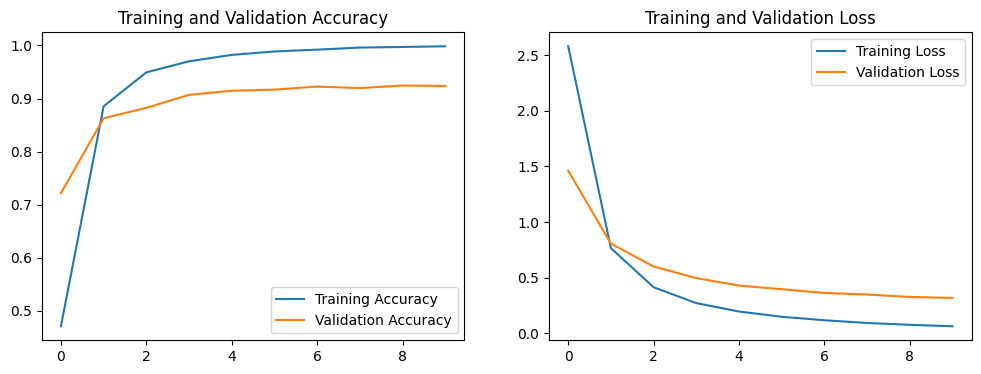

In [9]:
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(len(acc))

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

plot_history(history)

### Evaluation

In [10]:
test_loss, test_accuracy = model.evaluate(ds_test)
print(f'Test Accuracy: {test_accuracy:.4f}')

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9141 - loss: 0.3736
Test Accuracy: 0.9088
